In [ ]:
from dpc import DPC
from dpc import RandomSizedCrop, Normalize, ToTensor
from unet import UNet11
from unet import iou_dice_score_image

from PIL import Image
import unet.transform as T

from dataset import RMIS

from utils import utils
from pathlib import Path

import os
import torch
import numpy as np
import csv
import zipfile
import io
import cv2
import random

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
def get_model_with_weights(model, weights, use_gpu):
    
    unet_model = UNet11(num_classes = config.num_classes)
    
    if model == 'dpc-unet':
        dpc_model = DPC(sample_size = config.sample_size, num_seq=config.num_seq, seq_len=config.seq_len, upsample_size = config.upsample_size)

        if os.path.isfile(weights):
            checkpoint = torch.load(weights,
                                    map_location=torch.device('cpu'))
            dpc_model = utils.neq_load_customized(dpc_model,
                                                  checkpoint['dpc_state_dict'])
            unet_model = utils.neq_load_customized(unet_model,
                                      checkpoint['unet_state_dict'])
            if use_gpu:
                unet_model = unet_model.cuda()
                dpc_model = dpc_model.cuda()
            
            return dpc_model, unet_model
        else:
            print("=> no dpc_unet checkpoint found at '{}'".format(
                weights))
    elif model == 'unet':
        
        if os.path.isfile(weights):
            checkpoint = torch.load(weights,
                                    map_location=torch.device('cpu'))
            unet_model = utils.neq_load_customized(unet_model,
                                      checkpoint['state_dict'])
            
            if use_gpu:
                unet_model = unet_model.cuda()
            return unet_model
        else:
            print("=> no unet checkpoint found at '{}'".format(
                weights))

def visualize_masks(dpc_model, unet_model, vanilla_unet, video, img, mask, use_gpu):
    
    if use_gpu:
        video, img, mask = video.cuda(), img.cuda(), mask.cuda()
    
    video = video[None, ...]
    img = img[None, ...]
        
    with torch.no_grad():
        dpc_features = dpc_model(video)

        _, _, H, W = img.size()

        img_l, img_r = img[..., :H], img[..., W - H:W]
        
        vanilla_pred_mask_l = vanilla_unet(img_l).squeeze(1)
        vanilla_pred_mask_r = vanilla_unet(img_r).squeeze(1)

        pred_mask_l = unet_model(img_l, dpc_features).squeeze(1)
        pred_mask_r = unet_model(img_r, dpc_features).squeeze(1)
    

    
    pred_mask = utils.create_full_mask(pred_mask_l, pred_mask_r)
    vanilla_pred_mask = utils.create_full_mask(vanilla_pred_mask_l, vanilla_pred_mask_r)
    
    iou, dice = iou_dice_score_image(pred_mask, mask)
    vanilla_iou, vanilla_dice = iou_dice_score_image(vanilla_pred_mask, mask)
    

    pred_mask[pred_mask < 0.5] = 0.0
    pred_mask[pred_mask > 0.5] = 1.0
    
    vanilla_pred_mask[vanilla_pred_mask < 0.5] = 0.0
    vanilla_pred_mask[vanilla_pred_mask > 0.5] = 1.0
    
    img = img.squeeze(0)
    mask = mask.squeeze(0)
    pred_mask = pred_mask.squeeze(0)
    vanilla_pred_mask = vanilla_pred_mask.squeeze(0)
    
    img = img.permute(1, 2, 0)
    
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle('Segmentation Masks')
    
    axs = axs.flatten()
    
    
    axs[0].imshow(img.cpu().numpy())
    axs[0].set_title('Image')
    axs[1].imshow(mask.cpu().numpy(), cmap=plt.cm.gray)
    axs[1].set_title('Target Mask')
    axs[2].imshow(pred_mask.cpu().numpy(), cmap=plt.cm.gray)
    axs[2].set_title('DPC-Unet Predicted Mask')
    axs[3].imshow(vanilla_pred_mask.cpu().numpy(), cmap=plt.cm.gray)
    axs[3].set_title('Vanilla Unet Predicted Mask')
    
    fig.show()
    
    print(f"DPC-Unet --- IOU ::: {iou}, DICE ::: {dice}")
    print(f"Vanilla Unet --- IOU ::: {vanilla_iou},  DICE ::: {vanilla_dice}")
    
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [ ]:
class Eval_RMIS(RMIS):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def get_data(self, stage, surgery, patient, sample=None):
            sampled_video, last_frame, mask = None, None, None
            
            assert stage in ['Stage_1', 'Stage_2', 'Stage_3']
            assert surgery in ['Proctocolectomy', 'Rectal resection', 'Sigmoid']
            assert patient in [str(i) for i in range(1, 11)]
            
            if sample is not None:
                vpath = Path(self.data_path) / stage / surgery/ patient / sample
            else:
                temp_path = Path(self.data_path) / stage / surgery /  patient
                all_subdirs = []
                for root, _, _ in os.walk(temp_path):
                    all_subdirs.append(root)
                    
                vpath = Path(random.choice(all_subdirs[1:]))
                
                print(f"Sample ID --- {vpath.parts[-1]}")
                            
            
            assert vpath.is_dir()

            # print('Path of data sample: ', sample_path)
            data = []

            # sample frames
            # if returning image and target, the sample is the last frames of
            # the video
            # otherwise sample is sampled
            sampled_frame_idxs = self.idx_sampler(
                sample_last=False)

            # compressed frames
            compressed_video = zipfile.ZipFile(vpath / '10s_video.zip')

            # load required frames into memory
            sampled_video = []
            for frame_idx in sampled_frame_idxs:
                compressed_frame_png = f"{frame_idx}.png"

                # read png file as bytes
                frame_buf = compressed_video.read(compressed_frame_png)

                # convert into 1-d buffer array
                # np_buf = np.frombuffer(frame_buf, np.uint8)
                frame_enc = io.BytesIO(frame_buf)

                # decode buffer into numpy-image
                # np_img = cv2.imdecode(np_buf, cv2.IMREAD_UNCHANGED)
                img = Image.open(frame_enc)

                sampled_video.append(img)

            # apply video transforms
            if self.video_transforms:
                sampled_video = self.video_transforms(sampled_video)

            # self.video transforms must contain toTensor
            # to change dims [SN * SL, H, W, C] => [SN * SL, C, H, W ]
            C, H, W = sampled_video[0].shape

            # convert into required dim order
            # [SN * SL, C, H, W] => [SN, C, SL, H, W]
            sampled_video = torch.stack(sampled_video, 0)
            sampled_video = sampled_video.view(self.num_seq, self.seq_len, C,
                                               H, W).transpose(1, 2)

            data.append(sampled_video)

            # png files
            last_frame_png = vpath / 'raw.png'
            mask_png = vpath / 'instrument_instances.png'

            last_frame = Image.open(str(last_frame_png))

            W, H = last_frame.size

            # chekc if mask exists
            if mask_png.exists():
                # read last_frame
                mask = cv2.imread(str(mask_png), cv2.IMREAD_UNCHANGED)
                # convert to binary mask
                mask[mask > 0] = 1.
            else:
                # empty mask
                mask = np.zeros(shape=(H, W), dtype=np.uint8)

            # mask is now a PIL image
            mask = Image.fromarray(np.uint8(mask * 255), 'L')
            # apply last_frame_transforms

            if self.last_frame_transforms:

                last_frame, mask = self.last_frame_transforms(last_frame, mask)

            data.extend([last_frame, mask])

            return data

In [ ]:
use_gpu = torch.cuda.is_available()

In [ ]:
config = {
    # data config
    'data_path': '/mnt/disks/rmis_test/data',
    
    # dpc config
    'sample_size' : 128,
    'num_seq' : 5,
    'seq_len' : 5,
    'ds': 3,
    'upsample_size' : 33,
    
    # unet config
   'num_classes' : 1
}

config = dotdict(config)

# Model Architecture
![what dpc sees](./assets/dpc_unet.png)

In [ ]:
DPC_MODEL_WEIGHTS = './dpc_model_best.tar'
UNET_MODEL_WEIGHTS = './unet_model_best.tar'
DPC_UNET_MODEL_WEIGHTS = './best_dpc_unet_no_freeze.tar'

In [ ]:
dpc_transforms = transforms.Compose([
    RandomSizedCrop(size=config.sample_size, consistent=True, p=1.0),
    ToTensor(),
    Normalize()
])

unet_transforms = T.Compose([
    T.ToTensor(),
])


In [ ]:
dpc_model, unet_model = get_model_with_weights('dpc-unet', DPC_UNET_MODEL_WEIGHTS, use_gpu)
vanilla_unet = get_model_with_weights('unet', UNET_MODEL_WEIGHTS, use_gpu)

=> Using RNN + FC model 
=> Use 2D-3D resnet18!
=> using ConvRNN, kernel_size = 1

=======Check Weights Loading======
Weights not used from pretrained file:
---------------------------
Weights not loaded into new model:


=======Check Weights Loading======
Weights not used from pretrained file:
---------------------------
Weights not loaded into new model:


=======Check Weights Loading======
Weights not used from pretrained file:
---------------------------
Weights not loaded into new model:



In [ ]:
e = Eval_RMIS(mode='test',
data_path=config.data_path,
video_transforms=dpc_transforms,
last_frame_transforms=unet_transforms,
seq_len=config.seq_len,
num_seq=config.num_seq,
downsample=config.ds,
return_last_frame=True,
return_video=True)

Using Robust Medical Instrument Segmentation data
Read 4049 lines from /mnt/disks/rmis_test/data/test.csv


# DPC's perspective
![what dpc sees](./assets/individualImage.png)

# Visualizing samples

DPC-Unet --- IOU ::: 0.7994308765189834, DICE ::: 0.8885374669837248
Vanilla Unet --- IOU ::: 0.7734524970962189,  DICE ::: 0.8722562328121328


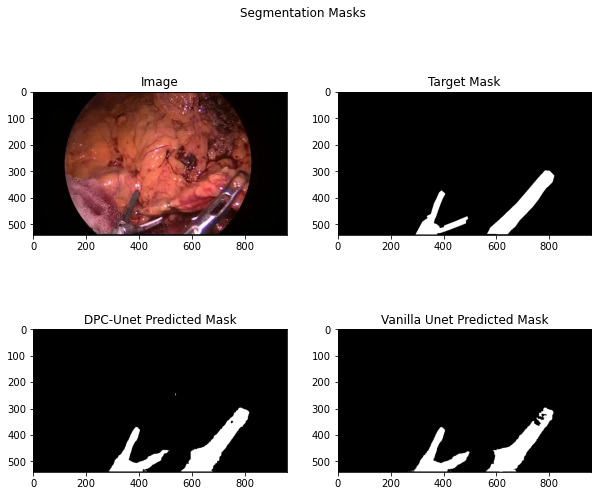

In [ ]:
v, i, m = e.get_data('Stage_3', 'Sigmoid', '9', '244825')
visualize_masks(dpc_model, unet_model, vanilla_unet, v, i, m, use_gpu)

DPC-Unet --- IOU ::: 0, DICE ::: 0
Vanilla Unet --- IOU ::: 0,  DICE ::: 0


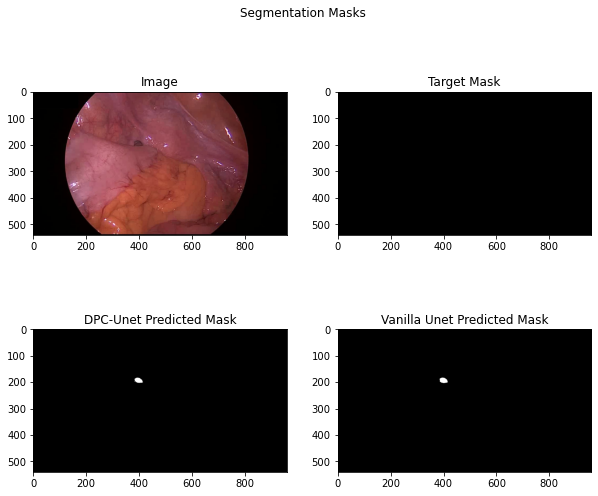

In [ ]:
v, i, m = e.get_data('Stage_3', 'Sigmoid', '9', '41994')
visualize_masks(dpc_model, unet_model, vanilla_unet, v, i, m, use_gpu)

Sample ID --- 417720
DPC-Unet --- IOU ::: 0.7199732671644097, DICE ::: 0.8371912295399838
Vanilla Unet --- IOU ::: 0.6579682318329579,  DICE ::: 0.7937042691059797


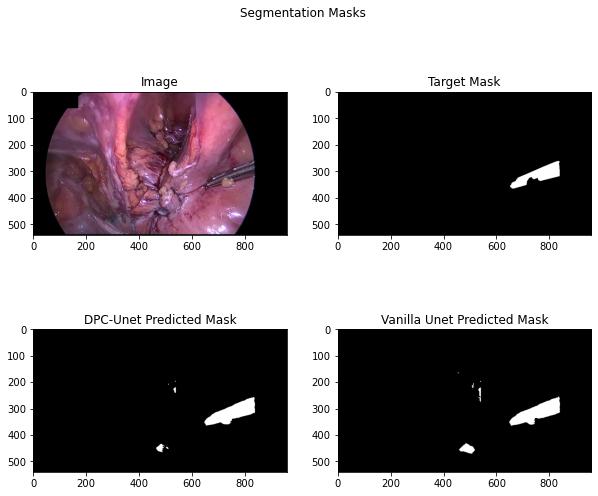

In [ ]:
#v, i, m = e.get_data('Stage_3', 'Sigmoid', '9', '244825')
#v, i, m = e.get_data('Stage_3', 'Sigmoid', '9', '41994')
#v, i, m = e.get_data('Stage_3', 'Sigmoid', '9', '97500')
#v, i, m = e.get_data('Stage_1', 'Proctocolectomy', '3', '116165')
v, i, m = e.get_data('Stage_1', 'Rectal resection', '1')
visualize_masks(dpc_model, unet_model, vanilla_unet, v, i, m, use_gpu)

DPC-Unet --- IOU ::: 0.6981299448645857, DICE ::: 0.8222338307780397
Vanilla Unet --- IOU ::: 0.680704359826013,  DICE ::: 0.8100227215379635


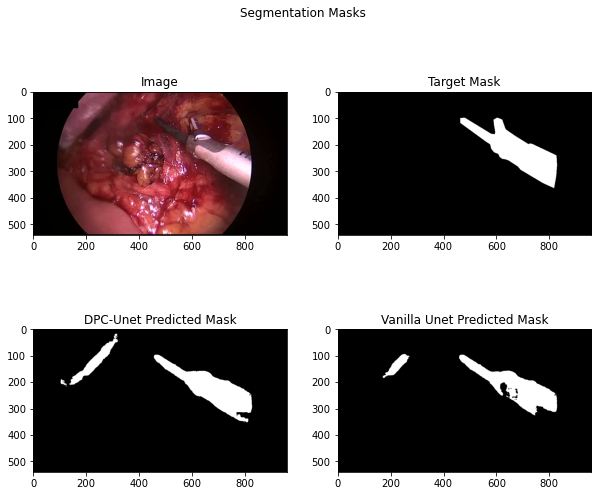

In [ ]:
v, i, m = e.get_data('Stage_3', 'Sigmoid', '9', '97500')
visualize_masks(dpc_model, unet_model, vanilla_unet, v, i, m, use_gpu)

DPC-Unet --- IOU ::: 0.7162190805261216, DICE ::: 0.8346476142261305
Vanilla Unet --- IOU ::: 0.5800513376840043,  DICE ::: 0.7342183432252273


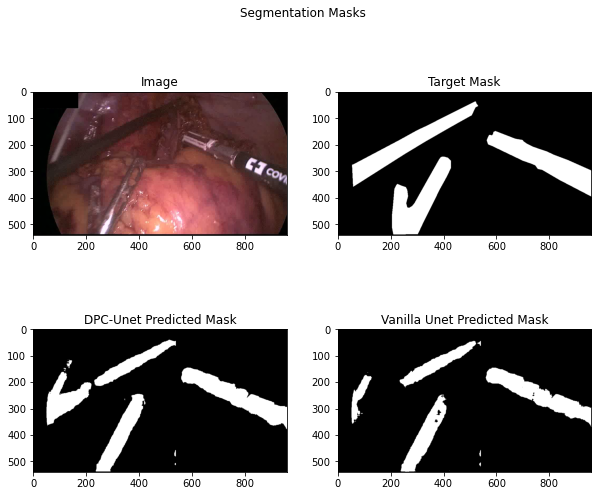

In [ ]:
v, i, m = e.get_data('Stage_1', 'Proctocolectomy', '3', '116165')
visualize_masks(dpc_model, unet_model, vanilla_unet, v, i, m, use_gpu)

DPC-Unet --- IOU ::: 0.6442128977819541, DICE ::: 0.7836125098507221
Vanilla Unet --- IOU ::: 0.585882174259348,  DICE ::: 0.7388722614660737


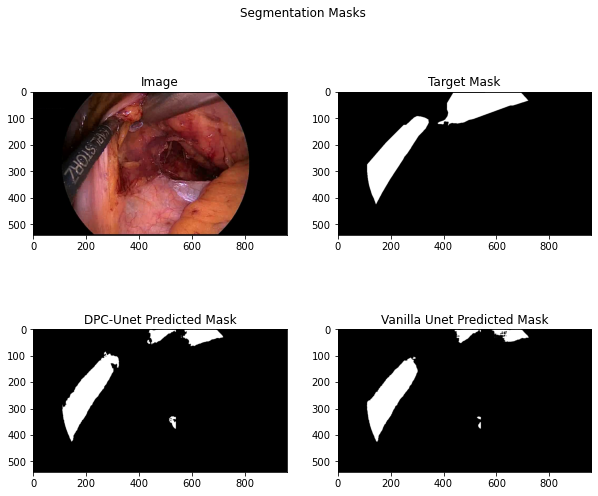

In [ ]:
v, i, m = e.get_data('Stage_1', 'Rectal resection', '6', '81000')
visualize_masks(dpc_model, unet_model, vanilla_unet, v, i, m, use_gpu)

Sample ID --- 170132
DPC-Unet --- IOU ::: 0.8775116664785564, DICE ::: 0.934760281008694
Vanilla Unet --- IOU ::: 0.758600785047387,  DICE ::: 0.8627322260911019


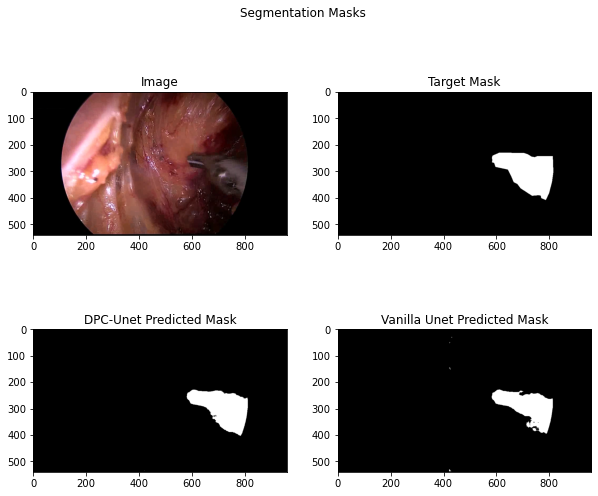

In [ ]:
v, i, m = e.get_data('Stage_2', 'Rectal resection', '5', '170132')
visualize_masks(dpc_model, unet_model, vanilla_unet, v, i, m, use_gpu)

Sample ID --- 13773
DPC-Unet --- IOU ::: 0.22722478151260148, DICE ::: 0.37030670327427617
Vanilla Unet --- IOU ::: 0.09114228197619823,  DICE ::: 0.16705847344971425


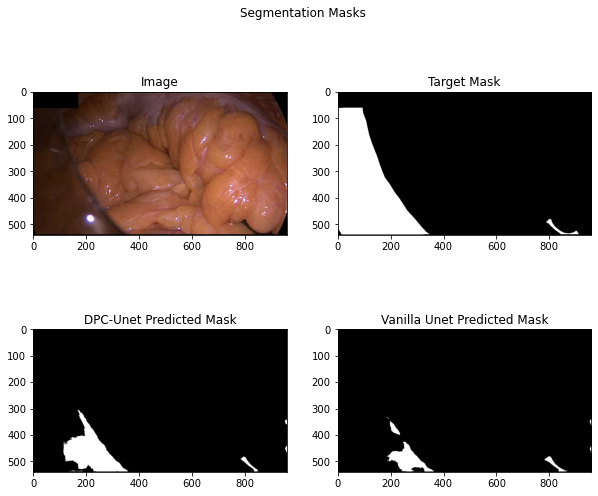

In [ ]:
v, i, m = e.get_data('Stage_3', 'Sigmoid', '3', '13773')
visualize_masks(dpc_model, unet_model, vanilla_unet, v, i, m, use_gpu)